In [1]:
# Starts the autoreload extension, which allows editing the .py files with the notebook running and automatically imports the latest changes

%load_ext autoreload
%autoreload 2

import trim_duplicates, model, network, gradcam, plots
from dataset import Dataset
import haiku as hk
import jax.numpy as jnp
import numpy as np
import jax
import sklearn
import wandb
from trim_duplicates import DuplicatesData
import matplotlib.pyplot as plt

assert jax.local_device_count() >= 8

NUM_CLASSES = 4
SEED = 14
BATCH_SIZE = 128

def basemodel_process(x): return x

In [2]:
rng = jax.random.PRNGKey(SEED)
dataset_mendeley = Dataset.load("data/mendeley", rng=rng, official_split=False)
dataset_tawsifur = Dataset.load("data/tawsifur", rng=rng, official_split=False)
print("Loaded mendeley", dataset_mendeley.classnames)
print("Loaded tawsifur", dataset_tawsifur.classnames)

tcmalloc: large alloc 7241465856 bytes == 0x8682a000 @  0x7fa005c8c680 0x7fa005cad824 0x7f9ffb21e4ce 0x7f9ffb27400e 0x7f9ffb274c4f 0x7f9ffb316924 0x5f5db9 0x5f698e 0x57195c 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x5f6343 0x570e46 0x56a0ba 0x5f6343 0x56cf2a 0x56a0ba 0x68d5b7 0x600f54 0x5c5530 0x56bddd 0x5004f8 0x56d80c 0x5004f8 0x56d80c 0x5004f8 0x5042c6 0x56bf09 0x5f6166
tcmalloc: large alloc 7241465856 bytes == 0x237158000 @  0x7fa005c8c680 0x7fa005cad824 0x7fa005cadb8a 0x7f9ddd986c37 0x7f9ddd9395eb 0x7f9ddd94a7a6 0x7f9ddd94b6dd 0x7f9dd97b4b09 0x7f9dd97b81a0 0x7f9ddd666302 0x7f9ddad61220 0x7f9ddad61910 0x7f9ddad3ce95 0x7f9ddad43686 0x7f9ddad45434 0x7f9dd89453bf 0x7f9dd86be9a8 0x7f9dd86ae540 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d
tcmalloc: large alloc 7241465856 bytes == 0x3e7690000 @  0x7fa005c8c680 0x7fa005cad824 0x7fa005cadb8a 0x7f9ddd986c37 0x7f9ddd9395eb 0x7f9ddd94a7a6 0x7f9ddd94b6dd 0x7f9dd97b4b09 0x7f9dd9

Loaded mendeley ['Normal', 'Viral pneumonia', 'COVID-19', 'Bacterial pneumonia']
Loaded tawsifur ['Normal', 'Viral pneumonia', 'COVID-19', 'Lung opacity']


tcmalloc: large alloc 16644833280 bytes == 0x1341490000 @  0x7fa005c8c680 0x7fa005cad824 0x7fa005cadb8a 0x7f9ddd986c37 0x7f9ddd9395eb 0x7f9ddd94a7a6 0x7f9ddd94b6dd 0x7f9dd97b4b09 0x7f9dd97b81a0 0x7f9ddd666302 0x7f9ddad61220 0x7f9ddad61910 0x7f9ddad3ce95 0x7f9ddad43686 0x7f9ddad45434 0x7f9dd89453bf 0x7f9dd86be9a8 0x7f9dd86ae540 0x5f5db9 0x5f698e 0x50b4c7 0x570e46 0x56a0ba 0x5f70bb 0x66600d 0x5f574e 0x56d5f6 0x56a0ba 0x5f6343 0x5f70f7 0x66600d


Total embed dups: 20917
Total pix dups: 20929
Complement of difference: 8
186 data/tawsifur/Normal/Normal-5456.png
6704 data/tawsifur/Normal/Normal-5275.png
3534 data/tawsifur/COVID-19/COVID-1120.png
14358 data/tawsifur/Normal/Normal-2141.png
19543 data/tawsifur/Normal/Normal-7498.png
9853 data/tawsifur/COVID-19/COVID-1127.png
17892 data/tawsifur/Normal/Normal-8932.png
16256 data/tawsifur/Normal/Normal-7040.png
19885 data/tawsifur/Lung_Opacity/Lung_Opacity-4251.png
5324 data/tawsifur/COVID-19/COVID-335.png
14775 data/tawsifur/Lung_Opacity/Lung_Opacity-2525.png
826 data/tawsifur/Normal/Normal-2427.png
7011 data/tawsifur/Normal/Normal-1600.png
7565 data/tawsifur/Normal/Normal-7242.png
21158 data/tawsifur/Normal/Normal-8517.png
4251 data/tawsifur/Normal/Normal-4374.png
4473 data/tawsifur/Normal/Normal-4163.png


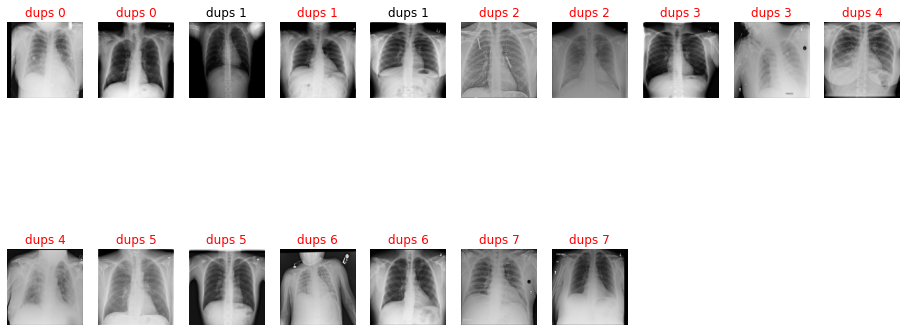

In [6]:
def show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/cv_" + actual_name + ".pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    print("Total embed dups:", len(dups.indices))
    print("Total pix dups:", len(dups_pix.indices))
    print("Complement of difference:", len(diff))
    
    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

show_diff(dataset_tawsifur, "embed")

Total embed dups: 6587
Total pix dups: 6580
Complement of difference: 23
1227 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1504).jpg
8107 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (2533).jpg
4856 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (300).jpg
9018 data/mendeley/Bacterial pneumonia/Pneumonia-Bacterial (1571).jpg


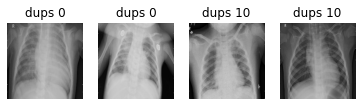

In [7]:
def custom_show_diff(ds, global_set, max_rows=4):
    actual_name = ds.name.split("/")[-1]
    dups = DuplicatesData.load("dup_data/" + actual_name + "_custom.pickle")
    dups_pix = DuplicatesData.load("dup_data/" + actual_name + "_pix.pickle")

    assert global_set == "embed" or global_set == "pix"

    if global_set == "embed":
        global_set = dups.indices
        other_set = dups_pix.indices
    else:
        global_set = dups_pix.indices
        other_set = dups.indices
    
    diff = global_set - dups.indices.intersection(dups_pix.indices)
    
    print("Total embed dups:", len(dups.indices))
    print("Total pix dups:", len(dups_pix.indices))
    print("Complement of difference:", len(diff))
    
    #assert jnp.all(ds.rng == dups.rng) and jnp.all(ds.rng == dups_pix.rng)

    other_dups_map = {}
    for group in other_set:
        if len(group) > 1:
            for i in group:
                other_dups_map[i] = True
        
    imgs = []
    for v in diff:
        imgs.append([])
        if len(v) > 1:
            for i in v:
                print(i, ds.paths_all[i])
                imgs[len(imgs)-1].append({ "img": ds.x_all[i,:,:,:], "color": "red" if i not in other_dups_map else "black" })
    
    plots.compare_n_images(imgs, rows=max_rows)

custom_show_diff(dataset_mendeley, "embed")

In [ ]:
dataset_mendeley.x_all.shape